# Reproducing “Identification of COVID-19 samples from chest X-Ray images using deep learning: A comparison of transfer learning approaches”

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shaivimalik/covid_illegitimate_features/blob/main/notebooks/Reproducing_Original_Result.ipynb)

## Introduction

In this notebook, we will reproduce the results published in
**Identification of COVID-19 samples from chest X-Ray images using deep
learning: A comparison of transfer learning approaches** \[1\]. This
study aims to recognize the chest X-ray images of COVID-19 cases from
normal and pneumonia cases. COVID-19, a highly contagious disease caused
by the SARS-CoV-2 coronavirus, is confirmed through RT-PCR testing. When
RT-PCR testing is unavailable or cost-prohibitive, chest X-ray image
diagnosis emerges as an alternative. Chest X-ray image diagnosis of
COVID-19 can play a crucial role in early screening and potentially
preventing COVID-19-related deaths. Several studies have employed
Convolutional Neural Networks (CNNs) to distinguish COVID-19 chest X-ray
images from those of other conditions, offering a promising approach for
rapid and accessible diagnosis.

In [ ]:
# Uncomment the following lines if running on Google Colab
#!git clone https://github.com/shaivimalik/covid_illegitimate_features.git
#!pip install -r covid_illegitimate_features/requirements.txt
#%cd covid_illegitimate_features/notebooks

## Retrieve the datasets

The study utilized chest X-ray images from two datasets:

-   **COVID-19 Image Data Collection**
    [2](COVID-19%20Image%20Data%20Collection:%20Prospective%20Predictions%20Are%20the%20Future%20Joseph%20Paul%20Cohen%20and%20Paul%20Morrison%20and%20Lan%20Dao%20and%20Karsten%20Roth%20and%20Tim%20Q%20Duong%20and%20Marzyeh%20Ghassemi%20arXiv:2006.11988,%202020)
    is a public open dataset of chest X-ray and CT images of patients
    which are positive or suspected of COVID-19 or other viral and
    bacterial pneumonias (MERS, SARS, and ARDS.). The images in this
    dataset were extracted from public databases, such as
    Radiopaedia.org, the Italian Society of Medical and Interventional
    Radiology, and Figure1.com, through manual collection and web
    scraping. The database is regularly updating with new cases.

-   **Chest X-Ray Images (Pneumonia)** \[3\] dataset consists of chest
    X-Ray images of 2 categories (Pneumonia/Normal). The images were
    selected from pediatric patients of one to five years old from
    Guangzhou Women and Children’s Medical Center, Guangzhou.

The code cell below will download the datasets. Then, we will create
TensorFlow Dataset objects and visualize chest X-ray images.

In [ ]:
!wget https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded
!unzip file_downloaded
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

We start by importing the required libraries.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from keras_cv import layers as layers_cv
# Set random seeds for reproducibility
np.random.seed(20)
tf.random.set_seed(20)

The **COVID-19 Image Data Collection** dataset contains chest X-ray
images of various lung diseases, so we need to filter and identify the
COVID-19 images. In this code cell, we extract the file paths of X-ray
images from COVID-19 patients and remove duplicates.

In [ ]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('covid-chestxray-dataset/metadata.csv')

# Filter the DataFrame to include only COVID-19 cases
df = df[df['finding']=='Pneumonia/Viral/COVID-19']

# Keep only X-ray images
df = df[df['modality']=='X-ray']

# Exclude images with 'L' view as the study uses frontal view images only
df = df[df['view']!='L']

# Remove duplicate patient entries, keeping the first occurrence
df.drop_duplicates(subset='patientid', keep='first', inplace=True)

We randomly select 300 chest X-ray images of normal and pnuemonia cases,
as reported in the paper. We create arrays `covid_paths`,
`normal_paths`, and `pneumonia_paths` to store the file paths of
COVID-19, normal, and pneumonia X-ray images.

In [ ]:
# Get list of COVID-19 image filenames
covid_files = df['filename'].to_list()
# Randomly select 260 COVID-19 images
covid_paths = np.random.choice(covid_files, size=260)
# Create full paths for COVID-19 images
covid_paths = ['covid-chestxray-dataset/images/' + i for i in covid_paths]

# Get list of Normal chest X-ray filenames
normal_files = os.listdir('chest_xray/train/NORMAL')
# Randomly select 300 Normal images
normal_paths = np.random.choice(normal_files, size=300)
# Create full paths for Normal images
normal_paths = ['chest_xray/train/NORMAL/' + i for i in normal_paths]

# Get list of Pneumonia chest X-ray filenames
pneumonia_files = os.listdir('chest_xray/train/PNEUMONIA')
# Randomly select 300 Pneumonia images
pneumonia_paths = np.random.choice(pneumonia_files, size=300)
# Create full paths for Pneumonia images
pneumonia_paths = ['chest_xray/train/PNEUMONIA/' + i for i in pneumonia_paths]

In [ ]:
# Print the number of samples for each class
print("Number of COVID-19 samples:", len(covid_paths))
print("Number of Normal samples:", len(normal_paths))
print("Number of Pneumonia samples:", len(pneumonia_paths))

Now, we use the `from_tensor_slices` method to create `tf.data.Dataset`
objects from the lists of paths.

In [ ]:
# Create TensorFlow datasets from the file paths
covid_ds = tf.data.Dataset.from_tensor_slices(covid_paths)
normal_ds = tf.data.Dataset.from_tensor_slices(normal_paths)
pneumonia_ds = tf.data.Dataset.from_tensor_slices(pneumonia_paths)

Next, we associate labels with each image and resize the images to
224x224 pixels using the `process_path` function.

In [ ]:
def process_path(file_path, label):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  img = tf.image.resize(img, [224, 224])
  return img, label

# Apply labels and process images for each dataset
labels = {"covid-19":0, "normal":1, "pneumonia":2}
covid_ds = covid_ds.map(lambda x: process_path(x,labels['covid-19']))
normal_ds = normal_ds.map(lambda x: process_path(x,labels['normal']))
pneumonia_ds = pneumonia_ds.map(lambda x: process_path(x,labels['pneumonia']))

Finally, we visualize the chest X-ray images of each class.

In [ ]:
# Load and display covid-19 x-ray image
keras.utils.load_img(covid_paths[5], color_mode='grayscale', target_size=(224,224))

In [ ]:
# Load and display normal x-ray image
keras.utils.load_img(normal_paths[5], color_mode='grayscale', target_size=(224,224))

In [ ]:
# Load and display pneumonia x-ray image
keras.utils.load_img(pneumonia_paths[5], color_mode='grayscale', target_size=(224,224))

## Reproducing results from “Identification of COVID-19 samples from chest X-Ray images using deep learning: A comparison of transfer learning approaches”

In this study, 15 pre-trained CNN models, originally trained on the
ImageNet dataset, were fine-tuned using transfer learning on chest X-ray
images from COVID-19 patients, regular pneumonia patients, and healthy
patients. The chest X-ray images were obtained from two sources:
COVID-19 Image Data Collection
[2](COVID-19%20Image%20Data%20Collection:%20Prospective%20Predictions%20Are%20the%20Future%20Joseph%20Paul%20Cohen%20and%20Paul%20Morrison%20and%20Lan%20Dao%20and%20Karsten%20Roth%20and%20Tim%20Q%20Duong%20and%20Marzyeh%20Ghassemi%20arXiv:2006.11988,%202020)
hosted on GitHub and a chest X-ray images \[3\] hosted on Kaggle.

The Kaggle dataset consists of 5,863 X-Ray images, from which 300 normal
and 300 pneumonia chest X-ray images were randomly chosen to create the
dataset. At the time of the study, the GitHub repository contained 340
CXR and CT images, of which 260 frontal CXR images were considered. The
number of images has increased since then, but to maintain consistency
with the paper, we will randomly select 260 CXR images. The datasets
were split according to the distribution shown below.

| 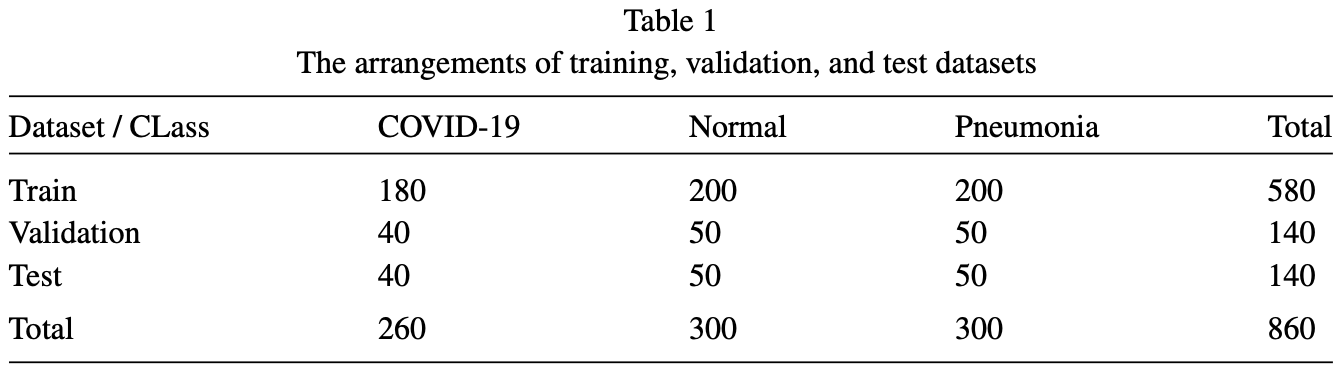 |
|:-------------------------------------------:|
|     *dataset split from original paper*     |

The images were resized to 224x224 pixels and the Keras
`preprocess_input` method was used to transform the input images to meet
the requirements of the models. Data augmentation was performed using
the Keras ImageDataGenerator API. However, as ImageDataGenerator is now
deprecated, we will use preprocessing layers from Keras in our
replication of the original results. The data augmentation strategy is
summarised in the table below:

|                                  |            |
|:--------------------------------:|:----------:|
|        **Rotation range**        | 20 degrees |
|    **Width and height shift**    |    10%     |
|         **Sheer scale**          |    10%     |
|          **Zoom range**          |    20%     |
| **Horizontal and vertical flip** |    True    |

The pre-trained models were imported without their classifier/top layer,
and their convolutional bases were frozen (`trainable = False`).The
output of the convolutional base was flattened to obtain a
one-dimensional vector, which was then passed through two fully
connected layers with ReLU activation (1024 and 512 neurons) and a final
fully connected layer with softmax activation. The model was trained
using an input size of (224x224x3), an initial learning rate of 0.001, a
batch size of 32, 50 epochs, and the RMSprop optimizer. To optimize
performance, ReduceLROnPlateau from Keras was used to reduce the
learning rate by a factor of 0.3 when the results stopped improving.

| 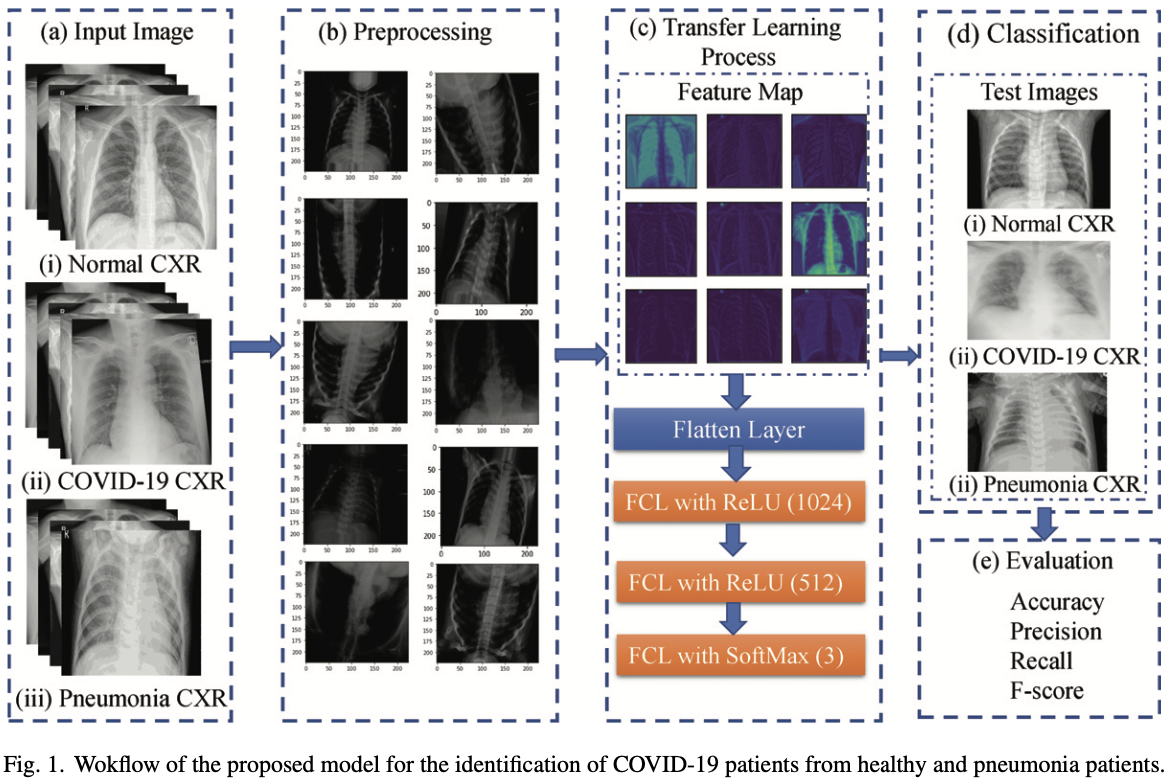 |
|:--------------------------------------:|
|   *workflow from the original paper*   |

To evaluate the models’ performance, precision, recall, F1 score, and
accuracy were calculated for each model.

| 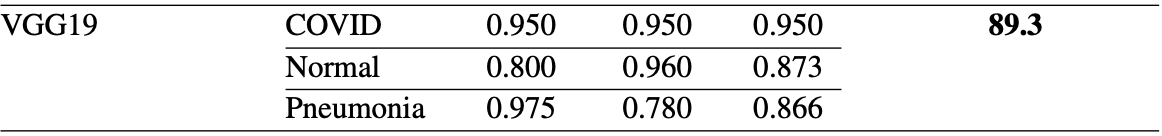 |
|:----------------------------------------------------------------------:|
| *reported performance analysis of VGG19 on test dataset from the original paper* |

| 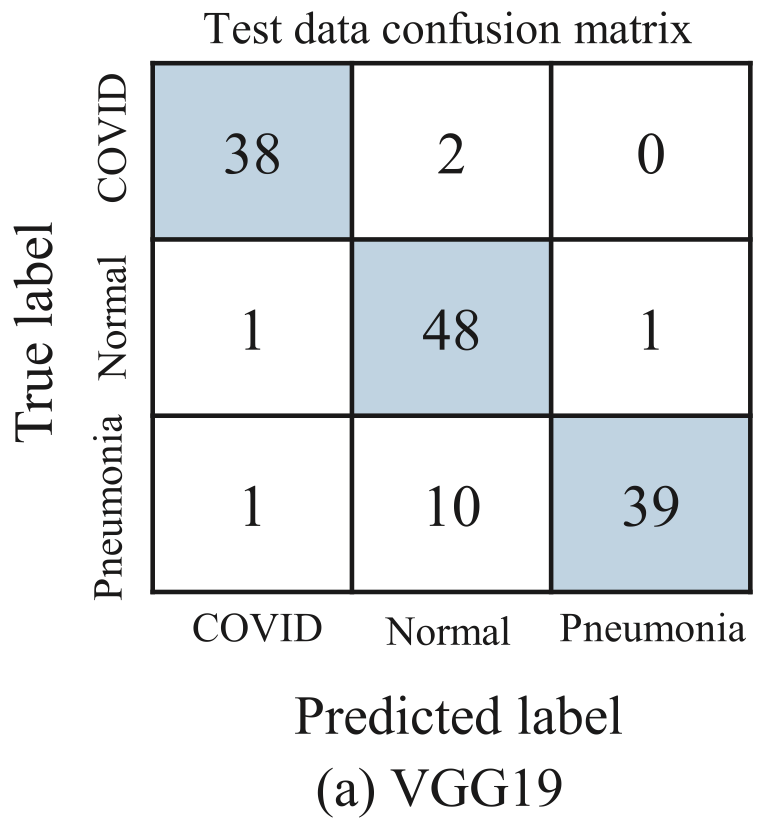 |
|:----------------------------------------------------------------------:|
| *confusion matrix of VGG19 generated on test dataset from the original paper* |

In this notebook, we will reproduce the model with the highest reported
accuracy: **VGG19 network with a flatten layer and three fully connected
layers**. We will train and evaluate the model using the datatsets and
metrics reported in the paper.

## Train and evaluate the convolutional neural network(VGG19) via Transfer Learning

In this section, we will train and evaluate our Convolutional Neural
Network following the methodology outlined in the paper:

-   Split the datasets into training, test, and validation sets.
-   Apply the data augmentation strategy.
-   Load the VGG19 model to extract features from the images.
-   Add two dense layers with ReLU activation.
-   Add a final dense layer with softmax activation.
-   Train the model for 50 epochs with a learning rate of 0.001 using
    the RMSprop optimizer.
-   Use ReduceLROnPlateau to adjust the learning rate when validation
    loss has stopped improving.
-   Report the model’s accuracy, confusion matrix, and class-wise
    precision, recall, and F1-score.

We start by splitting `covid_ds`, `normal_ds` and `pneumonia_ds`
according to the statistics given in the paper. We then concatenate
these splits to form training, test, and validation sets for model
training and evaluation. `keras.applications.vgg19.preprocess_input`
method is applied to preprocess the images, ensuring they are in the
correct format required by the VGG19 model.

In [ ]:
# Split datasets into train, validation, and test sets according to stats given in paper

# Splitting normal cases' x-ray images
normal_ds_train = normal_ds.take(200)
normal_remaining = normal_ds.skip(200)
normal_ds_val = normal_remaining.take(50)
normal_ds_test = normal_remaining.skip(50)

# Splitting pneumonia cases' x-ray images
pneumonia_ds_train = pneumonia_ds.take(200)
pneumonia_remaining = pneumonia_ds.skip(200)
pneumonia_ds_val = pneumonia_remaining.take(50)
pneumonia_ds_test = pneumonia_remaining.skip(50)

# Splitting covid cases' x-ray images
covid_ds_train = covid_ds.take(180)
covid_remaining = covid_ds.skip(180)
covid_ds_val = covid_remaining.take(40)
covid_ds_test = covid_remaining.skip(40)

In [ ]:
# Combine datasets
train_ds = (covid_ds_train.concatenate(normal_ds_train).concatenate(pneumonia_ds_train))
validation_ds = (covid_ds_val.concatenate(normal_ds_val).concatenate(pneumonia_ds_val))
test_ds = (covid_ds_test.concatenate(normal_ds_test).concatenate(pneumonia_ds_test))
# Preprocess the images in each dataset using VGG19 preprocess_input
train_ds = train_ds.map(lambda x, y: (keras.applications.vgg19.preprocess_input(x), y))
validation_ds = validation_ds.map(lambda x, y: (keras.applications.vgg19.preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (keras.applications.vgg19.preprocess_input(x), y))

In this cell, we create `RandomRotation` , `RandomTranslation`,
`RandomShear`, `RandomZoom` and `RandomFlip` data augmentation layers
and apply them on the training set.

In [ ]:
# Define data augmentation layers
augmentation_layers = [
    layers.RandomRotation(0.2), # Randomly rotate images by up to 20 degrees
    layers.RandomTranslation(0.1, 0.1), # Randomly translate images by up to 10% in x and y directions
    layers_cv.RandomShear(x_factor=0.1, y_factor=0.1), # Randomly shear images by up to 10% in x and y directions
    layers.RandomZoom(0.2), # Randomly zoom images by up to 20%
    layers.RandomFlip("horizontal_and_vertical") # Randomly flip images horizontally and vertically
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

# Apply data augmentation to training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

This code cell batches the datasets (`train_ds`, `validation_ds`, and
`test_ds`) into batches of 32 samples, uses prefetching to improve
performance, and caches the datasets in memory for faster subsequent
access.

In [ ]:
batch_size = 32
# Configure datasets for performance
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()

Next, we initialize the VGG19 model with weights pretrained on the
ImageNet dataset. By setting `include_top=False`, we exclude the final
classification layer of the VGG19 model. We set the `trainable`
attribute of the VGG19 layers to `False`. Then, we add a `Flatten` layer
to convert the VGG19 output into a one-dimensional vector. We follow
this with two `Dense` layers with ReLU activation, having 1024 and 512
neurons respectively. Finally, the output is fed into a `Dense` layer
with a softmax activation function.

In [ ]:
# Create a base model using VGG19 pre-trained on ImageNet
base_model = keras.applications.VGG19(
    weights="imagenet",  # Load weights pre-trained on ImageNet
    input_shape=[224, 224, 3],  # Specify input shape
    include_top=False,  # Do not include the ImageNet classifier at the top
)

# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

# Flatten the output of VGG19
x = layers.Flatten()(base_model.output)

# Add Dense layer with 1024 neurons and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add Dense layer with 512 neurons and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add final Dense layer with softmax activation for 3-class prediction
predictions = layers.Dense(3, activation='softmax')(x)

# Create the full model
model = keras.Model(inputs=base_model.input, outputs=predictions)

# Display model summary, showing which layers are trainable
model.summary(show_trainable=True)

We train the model on the training set using the RMSprop optimizer for
50 epochs. We use `sparse_categorical_crossentropy` as our loss function
since the labels are encoded as integers. We apply `ReduceLROnPlateau`
to reduce the learning rate by a factor of 0.3 when the validation loss
plateaus.

In [ ]:
# Compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=[keras.metrics.SparseCategoricalAccuracy()])

# Define learning rate reduction callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.3)

# Set number of training epochs
epochs = 50

# Train the model
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[reduce_lr])

We plot the training accuracy (`sparse_categorical_accuracy`) and
validation accuracy (`val_sparse_categorical_accuracy`) against the
number of epochs.

In [ ]:
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Here, we evaluate the model on the test set and report the accuracy.

In [ ]:
# Evaluate model on test set
loss, accuracy = model.evaluate(test_ds)
print('Test loss :', loss)
print('Test accuracy :', accuracy)

The following code cells display the true and predicted labels on the
test set and generate a confusion matrix.

In [ ]:
# Make predictions on test set
y_pred = model.predict(test_ds)
# Convert predicted probabilities to class labels by taking the index of the highest probability
y_pred = np.argmax(y_pred, axis=1)
print("Predictions:",y_pred)
# Extract true labels from the test dataset
y_true = tf.concat([label for _, label in test_ds], axis=0).numpy()
print("True labels:", y_true)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Create confusion matrix
conf_mat = confusion_matrix(y_true,y_pred)
# Display confusion matrix with labels
ConfusionMatrixDisplay(conf_mat,display_labels=labels.keys()).plot(cmap='Blues')

Finally, we report the class-wise precision, recall and f1-score of the
model’s performance on the test set.

In [ ]:
# Generate classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Print metrics for each class
for key in labels.keys():
  print("class:", key)
  print("Precision:",report[str(labels[key])]['precision'])
  print("Recall:",report[str(labels[key])]['recall'])
  print("F1-score:",report[str(labels[key])]['f1-score'])
  print()

Let’s save the model for future inference tasks.

In [ ]:
# Save the model
model.save('covid.keras')

In [ ]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Image titles for each class
image_titles = ['Covid', 'Normal', 'Pneumonia']

index = np.random.randint(-40, 0)

# Load images and Convert them to a Numpy array
covid = keras.utils.load_img(covid_paths[index], target_size=(224, 224))
normal = keras.utils.load_img(normal_paths[index], target_size=(224, 224))
pneumonia = keras.utils.load_img(pneumonia_paths[index], target_size=(224, 224))
images = np.asarray([np.array(covid), np.array(normal), np.array(pneumonia)])

X = np.array([tf.keras.utils.img_to_array(img) for img in images])

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Function to modify the model for GradCAM
def model_modifier_function(cloned_model): 
  cloned_model.layers[-1].activation = tf.keras.activations.linear

# Score function for GradCAM
def score_function(output): return (output[0][0], output[1][1], output[2][2])

# Create Gradcam object
gradcam = Gradcam(model, model_modifier=model_modifier_function, clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score_function, X)

# Rendering images with GradCAM heatmaps
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Discussion

|  Metric  | Reproduced Results | Original Results |
|:--------:|:------------------:|:----------------:|
| Accuracy |       92.14        |       89.3       |

We have successfully reproduced the results published in
**Identification of COVID-19 samples from chest X-Ray images using deep
learning: A comparison of transfer learning approaches** \[1\]. However,
the **Chest X-Ray Images (Pneumonia)** dataset contains images of
pediatric patients, which represents a different demographic from the
**COVID-19 Image Data Collection** dataset. As a result, the model has
learned features that may not be present in real-world data, leading to
data leakage of the type: **Model uses features that are not
legitimate**. Note that the test distribution is not representative of
real-world data about which the scientific claims are made, which
introduces another type of data leakage: Sampling bias in test
distribution. We continue our discussion on data leakage in the next
notebook.

## References

\[1\]: Rahaman, Md Mamunur et al. “Identification of COVID-19 samples
from chest X-Ray images using deep learning: A comparison of transfer
learning approaches.” Journal of X-ray science and technology vol. 28,5
(2020): 821-839. doi:10.3233/XST-200715

\[3\]: Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled
Optical Coherence Tomography (OCT) and Chest X-Ray Images for
Classification”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2